In [12]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import operator
import math
from matplotlib_venn import venn3, venn3_circles
pd.options.mode.chained_assignment = None

from util.api import compute_monad_usage_by_df, calculate_bottom, get_lts_list, compute_monad_transformer_usage_by_df, compute_other_monad_usage_by_df

%matplotlib inline
plt.style.use('classic')

In [13]:
lts_list = get_lts_list()
df_list = []
df_by_category_list = []

for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/dfs/lts-{lts}/lts-{lts}.df')
    df_list.append(df)

# Research Questions (RQs)

- **RQ 1.** What packages are the most used? Which of them are outside from the Stackage selection?
- **RQ 2.** How many dependencies of packages are outside from the Stackage selection (in)directly?
- **RQ 3.** How frequently are the packages updated? 

Regarding monads, we analyze the evolution of dependencies of monad modules available in the mtl package:

- **RQ 4.** How have these monad packages evolved?
- **RQ 5.** How has the use of monads evolved?
- **RQ 6.** How many packages that depend on the mtl and transformers packages are added and removed in Stackage? How many packages that depended on these monads package stopped their dependencies?

## RQ 5.  How has the use of monads evolved?

Para responder esta pregunta fueron necesarios los datos obtenidos despues analizar estaticamente (parsear) el codigo de cada paquete. El primer paso fue contabilizar por cada LTS la cantidad de paquetes que utiliza cada monada usando los campos de tipo flag descritos. Con estos datos prodecimos a calcular el valor porcentual respecto al total de monadas utilizadas en cada LTS para finalmente, visualizar la distribucion del uso de las monadas en un grafico de barra por cada version.

- Existe una relacion inversamente proprcional entre el uso de monadas de error y de execpcion.
- Se produjo una considerable adopcion del uso de la monada de excepcion, que paso de tener un uso casi nulo al comienzo a alcanzar casi el 10% del uso de la monadas en la version 16-22
- Obeservamos que la monada de estados se mantiene liderando la distrubcion a lo largo del tiemp
- En general las distrubciones tienen pocas variaciones a pesar de haber aumentado la cantidad de paquetes 3 veces entre el primer y ultimo lts

In [14]:
transformers_type = ['State','Reader', 'Writer', 'Except', 'Identity', 'RWS', 'Class', 'Cont', 'Maybe']
transformers_type_df_list = []
data_transformers = [[], [], [], [], [], [], [], [], []]

for idx, df in enumerate(df_list):
    mtl_df = compute_monad_transformer_usage_by_df(df)
    monad_type_series = mtl_df[transformers_type].sum().sort_values()
    monad_type_df = pd.DataFrame({ "type": monad_type_series.index, "count": monad_type_series.values })
    transformers_type_df_list.append(monad_type_df)

for num, monad in enumerate(transformers_type):    
    for idx, lts in enumerate(lts_list):
        aux = int(transformers_type_df_list[idx][transformers_type_df_list[idx]['type'] == monad]['count'])
        sum = transformers_type_df_list[idx].sum().values[1]
        per = aux * 100 / sum
        data_transformers[num].append(per)

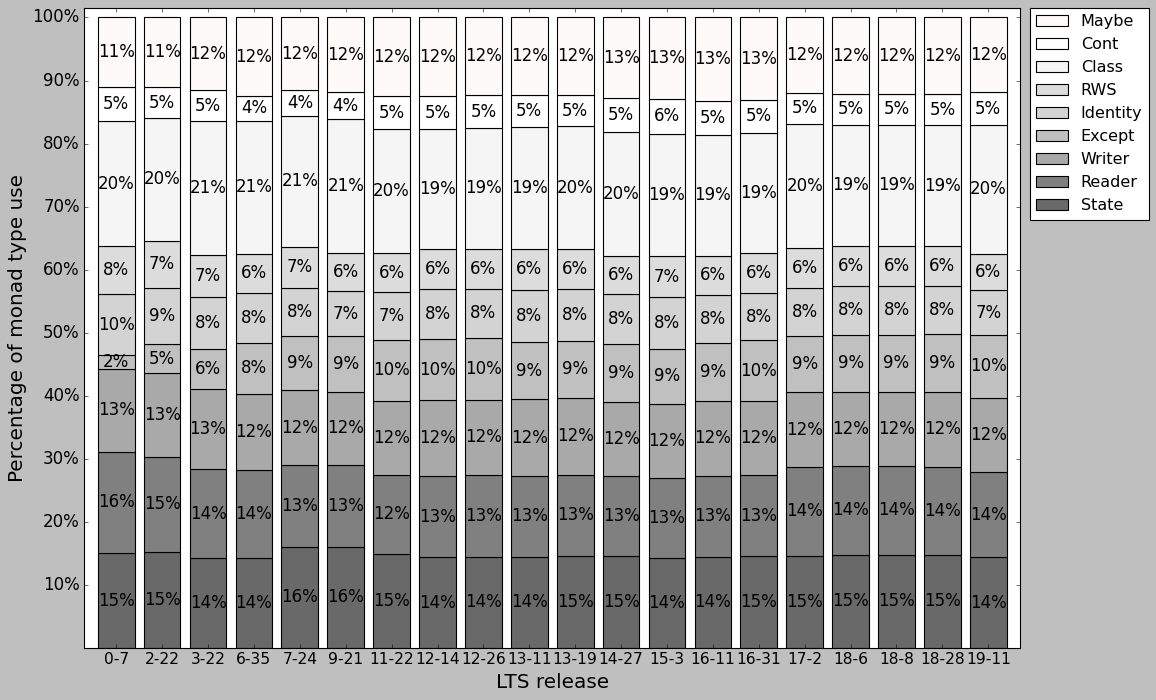

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

colors = ['dimgrey', 'grey', 'darkgrey', 'silver', 'lightgrey', 'gainsboro', 'whitesmoke', 'white', 'snow']
for idx, monad in enumerate(transformers_type):
    bar = ax.bar(x=lts_list, height=data_transformers[idx], bottom=calculate_bottom(data_transformers, idx), width=.8, color=colors[idx], align='center', label=monad)
    ax.bar_label(bar, labels=list(map(lambda per: f"{round(per)}%", data_transformers[idx])), label_type='center', color='black',fontsize=15)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

ax.set_xticks(lts_list)
ax.set_xticklabels(lts_list,fontsize=14)
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],fontsize=15)
ax.set_xlabel('LTS release',fontsize=18)
ax.set_ylabel('Percentage of monad type use',fontsize=18)

plt.savefig("../../graphs/rq5_transformers.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [16]:
monads_type = ['State', 'Reader', 'Trans', 'Writer', 'Error', 'Except', 'Identity', 'RWS', 'Continuation', 'List']
monads_type_df_list = []
data = [[], [], [], [], [], [], [], [], [], []]

for idx, df in enumerate(df_list):
    mtl_df = compute_monad_usage_by_df(df)
    monad_type_series = mtl_df[monads_type].sum().sort_values()
    monad_type_df = pd.DataFrame({ "type": monad_type_series.index, "count": monad_type_series.values })
    monads_type_df_list.append(monad_type_df)
    
for num, monad in enumerate(monads_type):    
    for idx, lts in enumerate(lts_list):
        aux = int(monads_type_df_list[idx][monads_type_df_list[idx]['type'] == monad]['count'])
        sum = monads_type_df_list[idx].sum().values[1]
        per = aux * 100 / sum
        data[num].append(per)

for i in range (len(data[1])):
    data[8][i] = data[8][i]+data[9][i]

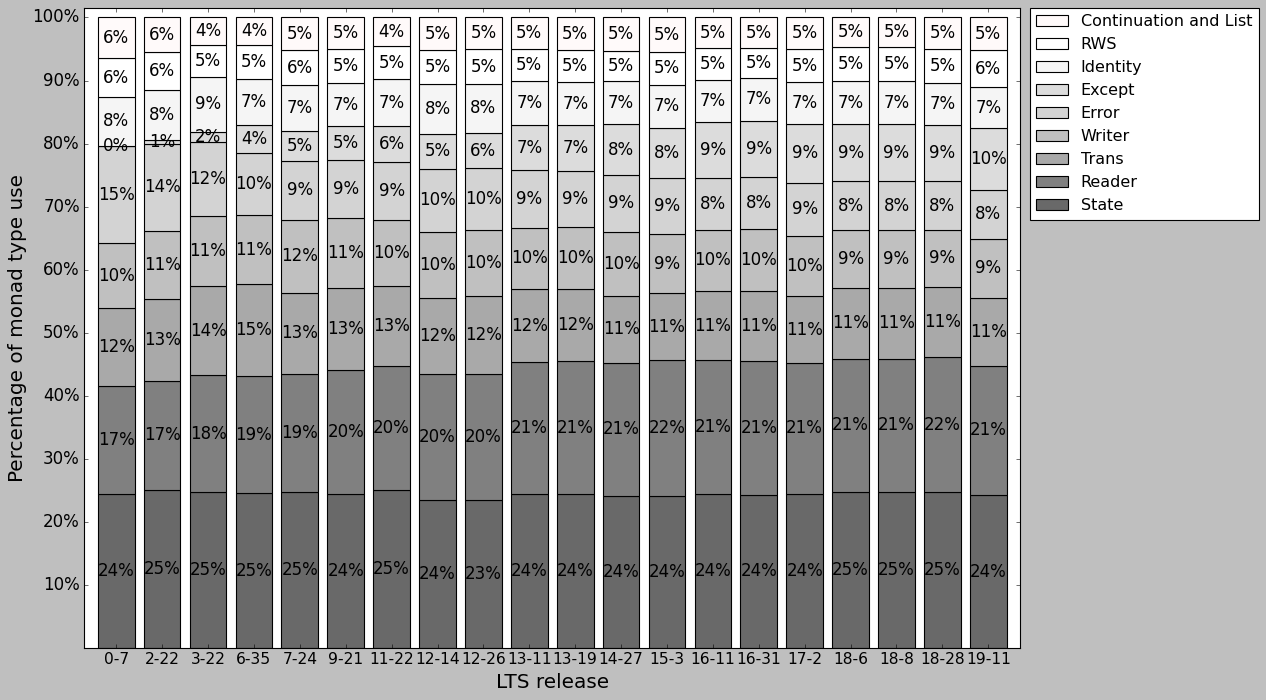

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

monads_type = ['State', 'Reader', 'Trans', 'Writer', 'Error', 'Except', 'Identity', 'RWS', 'Continuation and List']
colors = ['dimgrey', 'grey', 'darkgrey', 'silver', 'lightgrey', 'gainsboro', 'whitesmoke', 'white', 'snow', 'slategrey']
for idx, monad in enumerate(monads_type):
    bar = ax.bar(x=lts_list, height=data[idx], bottom=calculate_bottom(data, idx), width=.8, color=colors[idx], align='center', label=monad)
    ax.bar_label(bar, labels=list(map(lambda per: f"{round(per)}%", data[idx])), label_type='center', color='black',fontsize=15)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

ax.set_xticks(lts_list)
ax.set_xticklabels(lts_list,fontsize=14)
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],fontsize=15)
ax.set_xlabel('LTS release',fontsize=18)
ax.set_ylabel('Percentage of monad type use',fontsize=18)

plt.savefig("../../graphs/rq5_mtl.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [18]:
monads_type = ['Control','Free']
monads_type_df_list = []
data = [[], [], [], [], [], [], []]

for idx, df in enumerate(df_list):
    mtl_df = compute_other_monad_usage_by_df(df)
    monad_type_series = mtl_df[monads_type].sum().sort_values()
    monad_type_df = pd.DataFrame({ "type": monad_type_series.index, "count": monad_type_series.values })
    monads_type_df_list.append(monad_type_df)
    
for num, monad in enumerate(monads_type):    
    for idx, lts in enumerate(lts_list):
        aux = int(monads_type_df_list[idx][monads_type_df_list[idx]['type'] == monad]['count'])
        sum = monads_type_df_list[idx].sum().values[1]
        per = aux * 100 / sum
        data[num].append(per)

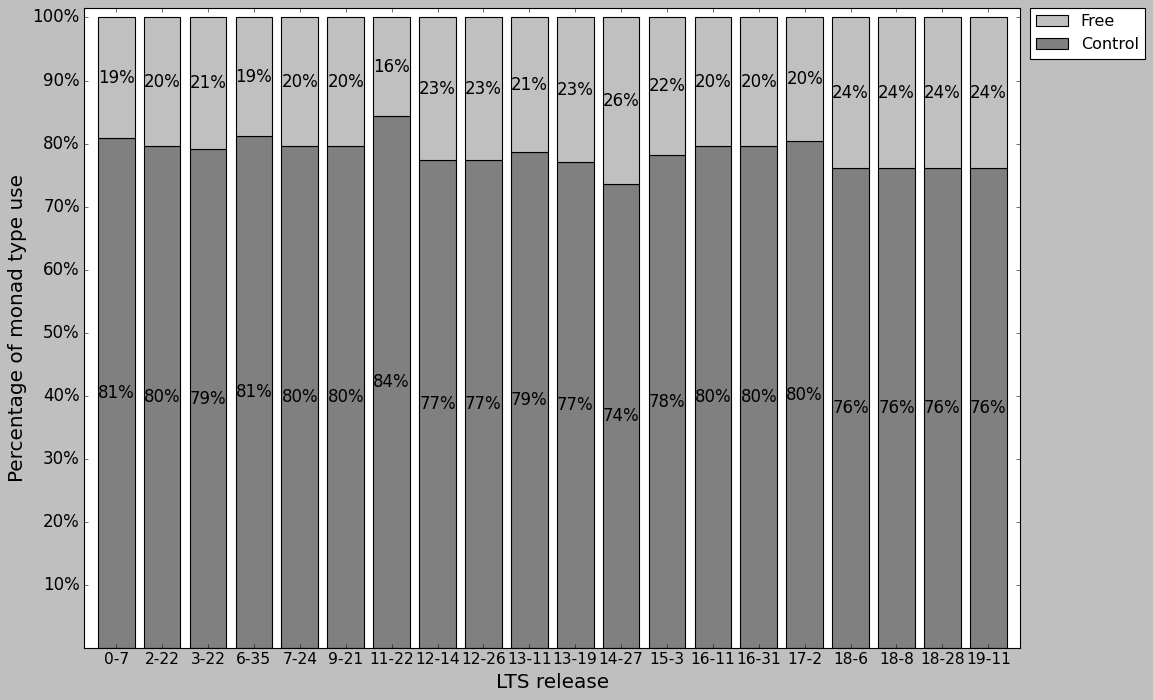

In [19]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.margins(0.015) 
plt.subplots_adjust(right=1.1)

colors = ['grey', 'silver']
for idx, monad in enumerate(monads_type):
    bar = ax.bar(x=lts_list, height=data[idx], bottom=calculate_bottom(data, idx), width=.8, color=colors[idx], align='center', label=monad)
    ax.bar_label(bar, labels=list(map(lambda per: f"{round(per)}%", data[idx])), label_type='center', color='black',fontsize=15)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

ax.set_xticks(lts_list)
ax.set_xticklabels(lts_list,fontsize=14)
ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_yticklabels(['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],fontsize=15)
ax.set_xlabel('LTS release',fontsize=18)
ax.set_ylabel('Percentage of monad type use',fontsize=18)

plt.savefig("../../graphs/rq5_other_monads.pdf", format='pdf', bbox_inches='tight')
plt.show()